In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

dict_keys(['__header__', '__version__', '__globals__', 'Ethanol', 'NIR'])
(166, 235) (166, 1)
(100, 1) (66, 1)
(235,)


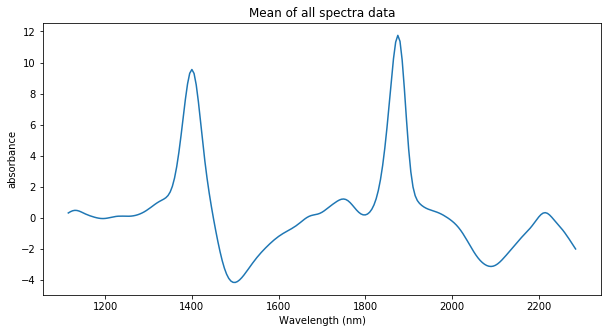

In [3]:
data = io.loadmat('./Question1-3.mat')
print(data.keys())

NIR = data['NIR']
ethanol = data['Ethanol']
print(NIR.shape, ethanol.shape)

x_train = NIR[0:100, :]
y_train = ethanol[0:100, :]

x_test = NIR[100:, :]
y_test = ethanol[100:, :]

print(y_train.shape, y_test.shape)

NIR_avg = x_train.mean(axis=0)
print(NIR_avg.shape)
plt.figure(figsize=(10,5))
plt.plot(np.linspace(1115, 2285, 235), NIR_avg)
plt.title('Mean of all spectra data')
plt.xlabel("Wavelength (nm)")
plt.ylabel("absorbance")
plt.savefig("mean_NIR.png")

## Cubic B-splines 

In [4]:
# helper function from example code
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. 
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. 

    If K = length(knots) (includes boundary knots)
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    
    augmented_knots = np.append(np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree + 1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF), degree, extrapolate=False)
    B = spline(x)
    return B

12


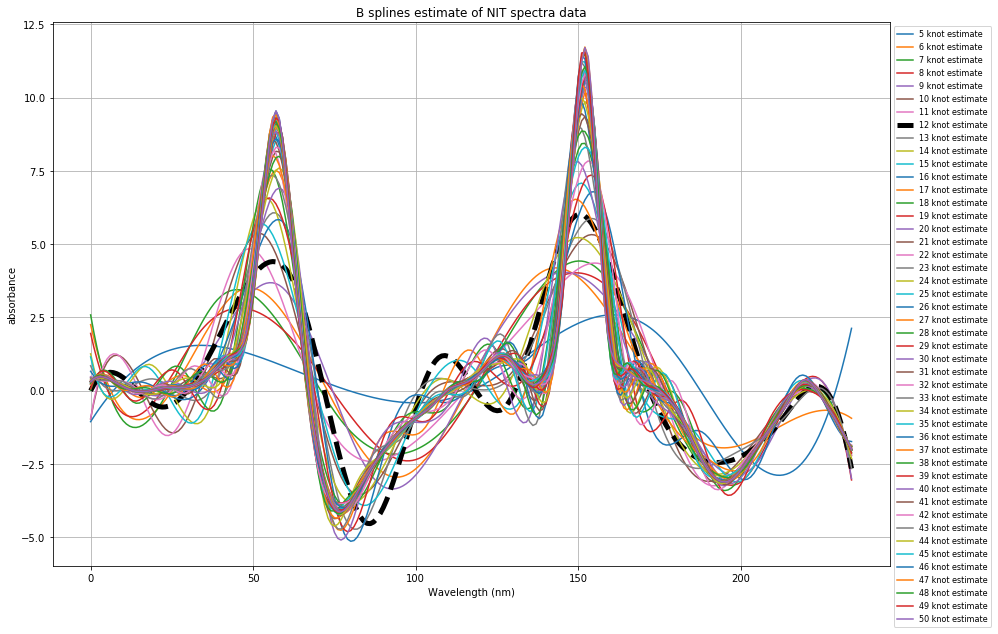

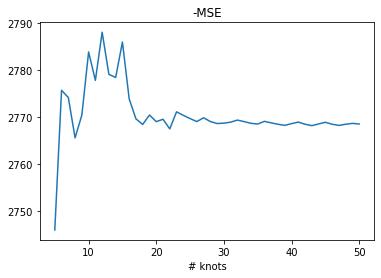

In [10]:
plt.figure(figsize=(15,10))
deg = 3
MSE_bsplines = []
optimal_bspline = np.zeros((235,))

for k in range(5, 51):
    # 5-fold CV
    kf = KFold(n_splits=5) #, shuffle=True)
    kf.get_n_splits(x_train)
    errs = []
    count = 0
    for trg, tst in kf.split(x_train):

        knots = np.linspace(0, 1, k)
        xx = np.linspace(0, 1, x_train[trg].shape[1])
        #print(xx.shape)
        B = BSplineBasis(xx, knots, deg)[:,:-2]
        #print(B.shape, x_train.T.shape)
        Bcoef = np.linalg.lstsq(B, x_train[trg].T, rcond=None)[0].T
        #print(B.shape, Bcoef.shape)
        y_splines = B@Bcoef.mean(axis=0)
        #print(y_splines.shape)
    
        
        errs.append(((y_splines[tst] - np.squeeze(y_train[tst]))**2).sum())
        if count == 0:
            if k == 12:
                optimal_bspline = y_splines
                plt.plot(y_splines, 'k--', linewidth=5, label=f'{k} knot estimate')
            else:
                plt.plot(y_splines, label=f'{k} knot estimate')
            
        count += 1
    
    #print(np.asarray(errs).shape)
    MSE_bsplines.append(np.asarray(errs).mean() / y_train[tst].shape[0])


optimal_k = np.argmax(MSE_bsplines) + 5
print(optimal_k)

plt.legend(bbox_to_anchor =(1, 1), fontsize=8)
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("absorbance")
plt.title('B splines estimate of NIT spectra data')
plt.savefig("optimal_knot.png")
plt.show()

plt.plot(list(range(5, 51)), MSE_bsplines)
plt.xlabel("# knots")
plt.title("-MSE")
plt.savefig("bspline_mse.png")

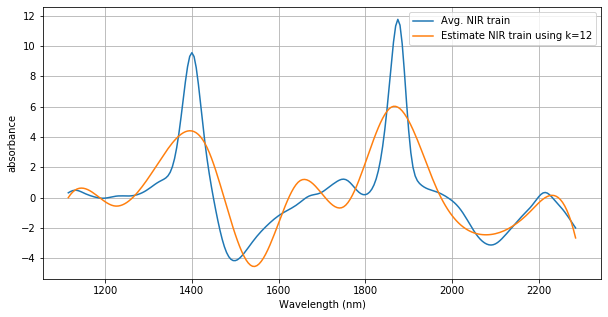

In [7]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(1115, 2285, 235), NIR_avg, label='Avg. NIR train')
plt.plot(np.linspace(1115, 2285, 235), optimal_bspline, label='Estimate NIR train using k=12')

plt.legend(bbox_to_anchor =(1, 1), fontsize=10)
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("absorbance")
plt.savefig("NIR_avg_k12.png")
plt.show()

In [109]:
# Linear Regression
k = 12
deg = 3
x = np.linspace(0, 1, x_train.shape[1])
xx = np.linspace(0, 1, x_test.shape[1])
#print(x.shape, xx.shape)
knots = np.linspace(0, 1, )

B = BSplineBasis(x, knots, deg)[:,:-2]
B_test = BSplineBasis(xx, knots, deg)[:,:-2]

Bcoef = np.linalg.lstsq(B, x_train.T, rcond=None)[0].T
Bcoef_test = np.linalg.lstsq(B_test, x_test.T, rcond=None)[0].T

reg = LinearRegression().fit(Bcoef, y_train)

pred = reg.predict(Bcoef)
pred_test = reg.predict(Bcoef_test)

RSS_ethanol = np.sum((pred - y_train)**2)
MSE_ethanol = np.sum((pred_test - y_test)**2) / y_test.shape[0]
print(RSS_ethanol, MSE_ethanol)

23.161029409501324 17.57515616498385


235
(235, 14) (14, 166)
(166, 235)


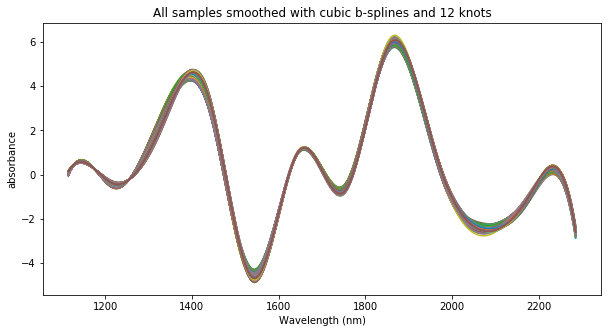

In [8]:
# FPCA

deg=3
knots = np.linspace(0, 1, 12)
xx = np.linspace(0, 1, NIR.shape[1])
print(NIR.shape[1])
B = BSplineBasis(xx, knots, deg)[:,:-2]
#print(B.shape, x_train.T.shape)
Bcoef = np.linalg.lstsq(B, NIR.T, rcond=None)[0]
print(B.shape, Bcoef.shape)
y_splines = B@Bcoef
print(y_splines.T.shape)

plt.figure(figsize=(10,5))
for sample in range(y_splines.T.shape[0]):
    plt.plot(np.linspace(1115, 2285, 235), y_splines.T[sample,:])
    
plt.title("All samples smoothed with cubic b-splines and 12 knots")
plt.xlabel("Wavelength (nm)")
plt.ylabel("absorbance")
plt.savefig("bspline_smoothed.png")
plt.show()

In [132]:
#X = np.vstack([x_train, x_test])
mu_hat = gaussian_filter(NIR.mean(0),3)
print(mu_hat.shape)

diffs = NIR-mu_hat
print(diffs.shape)
Cov = np.cov(diffs.T)
l, psi = np.linalg.eigh(Cov)
print(psi.shape)
PCs = psi[:, -5:]
print(PCs.shape)
FPC_scores = diffs.dot(PCs)
print(FPC_scores.shape)

reg = LinearRegression().fit(FPC_scores[0:100,:], y_train)

pred = reg.predict(FPC_scores[0:100,:])
pred_test = reg.predict(FPC_scores[100:,:])

RSS_ethanol = np.sum((pred - y_train)**2)
MSE_ethanol = np.sum((pred_test - y_test)**2) / y_test.shape[0]
print(RSS_ethanol, MSE_ethanol)

(235,)
(166, 235)
(235, 235)
(235, 5)
(166, 5)
1869.148195537662 83.32228346476063


In [129]:
pca = PCA(n_components=10)
pca.fit_transform(NIR)
print(pca.explained_variance_ratio_.cumsum())

[0.82484945 0.9555833  0.98149417 0.9879171  0.99247535 0.9937612
 0.99459591 0.99538212 0.99601444 0.99641889]
